In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from scipy.fft import rfft, rfftfreq
from scipy.fft import fft2
from skimage.filters import window


import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())


def plot_temporal_profile(sta, dt):
    tap = sta.shape[0]
#     figsize = (5.5,3.5)
#     plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    plt.ylabel('STA')
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    # print('PSNR = {:.2f}'.format(psnr(sta)))

    plt.title('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel('ms')
    
    
def plot_temporal_spectrum(sta, dt):
    wt = rfft(sta, axis=1)
    
    N = sta.shape[1]
    fs = rfftfreq(N, dt)
    
    plt.plot(fs, np.abs(wt.T), 'o-')
    plt.xlabel('Hz')
    plt.ylabel('FFT amplitude')

    box_off()


def plot_spatial_spectrum(sta_slice, windowing='hann', pixel_size=1, precision=2):
    assert len(sta_slice.shape)==2
    
    def set_ticks(ax, fs, precision=precision):
        ticks = range(0, len(fs))
        print_format = "{:." + str(precision) + "f}"
        ticklabels = [print_format.format(p) for p in (fs)]

        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
        ax.set_xlim(-0.5, len(fs)-0.5)
#         from matplotlib.ticker import FormatStrFormatter
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels)
        ax.set_ylim(-0.5, len(fs)-0.5)

        
    w = fft2(sta_slice * window(windowing, sta_slice.shape))

    fs = rfftfreq(sta_slice.shape[0])
    
    # crop and take abs w 
    abs_w = np.abs(w[:len(fs),:len(fs)])
    plt.imshow(abs_w, cmap='gray', origin='lower')

    set_ticks(plt.gca(), fs, precision=precision)
    
    plt.xlabel('frequency')
    plt.ylabel('frequency')
    
    abs_w[0,0] = - np.Inf
    idx_max = np.unravel_index(np.argmax(abs_w, axis=None), abs_w.shape)
    plt.plot(idx_max[1],idx_max[0], 'r*')
    
    
    
def plot_spatio_temporal(sta, height=13, width=13, dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    
    plot_temporal_profile(sta, dt)
    
    
#     pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
#     if ylabel is not None:
#         plt.ylabel(ylabel)
#     print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     print('PSNR = {:.2f}'.format(psnr(sta)))
# #     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=height, width=width, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')
    
    plt.xlim(-0.5, len(group_values)-0.5)
    box_off()

In [3]:
def calc_spatial_spectrum(sta_reg):
    # find pixel with highest variance
    idx_max_var = np.argmax(np.var(sta_reg,axis=0))
    temporal_profile = sta_reg[:,idx_max_var]

    plt.figure(figsize=(12,4))
    plt.plot(temporal_profile, '.-')
    idx_peak = np.argmax(np.abs(temporal_profile))

    sta_slice = sta_reg[idx_peak,:].reshape(height,width)
    plt.plot(idx_peak, sta_reg[idx_peak, idx_max_var], 'r*')
    plt.xlabel('frame')
    plt.ylabel('STA at pixel {}'.format(idx_max_var))
    box_off()


    sta_slice = sta_reg[idx_peak,:].reshape(height,width)


    plt.figure(figsize=(15,8))
    plt.subplot(121)
    plt.imshow(sta_slice, cmap='gray', origin='lower')

    plt.subplot(122)
    plot_spatial_spectrum(sta_slice)

## load data

In [4]:
# data_path = 'data'

# # dataset = '20201209'
# # width = 26
# # height = 26

# # dataset = '20201216'
# # width = 13
# # height = 13

# dataset = '20180626'
# width = 8
# height = 8
# fps = 10

In [5]:
# gaussian stim with the highest contrast
data_path = 'data_gaussian'
dataset = 'contrast100'
dataset = 'contrast50'

width = 8
height = 8
fps = 10

In [6]:
# different spatial & temporal resolutions (2018.08.28)
data_path = 'data_binary_stim'

# width = 8
# height = 8
# fps = 10

# width = 8
# height = 8
# fps = 25

# width = 13
# height = 13
# fps = 10

width = 26
height = 26
fps = 10

dataset = '20180828_{}pix_{}Hz'.format(width,fps)
dataset

'20180828_26pix_10Hz'

In [7]:
# cloud stim data (2021.02.03)
# ln -s ~/data/cloud_stim_data data_cloud_stim
data_path = 'data_cloud_stim'
dataset = '20210203_contrast100'
width = 52
height = 52
fps = 30

# dataset = '20210113'
# width = 26
# height = 26
# fps = 10

In [8]:
# cloud stim data (2021.01.13)
# ln -s ~/data/cloud_stim_data data_cloud_stim
data_path = 'data_cloud_stim'

dataset = '20210113'
width = 26
height = 26
fps = 10

In [9]:
data = np.load(os.path.join(data_path, dataset + '.npz'))
info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))


stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

111

(array([3.00000e+02, 5.31000e+03, 8.19600e+04, 8.93940e+05, 3.18957e+06,
        3.08703e+06, 7.82610e+05, 6.68400e+04, 4.14000e+03, 3.00000e+02]),
 array([-0.9182904 , -0.73335043, -0.54841046, -0.36347049, -0.17853053,
         0.00640944,  0.19134941,  0.37628938,  0.56122935,  0.74616932,
         0.93110929]),
 <BarContainer object of 10 artists>)

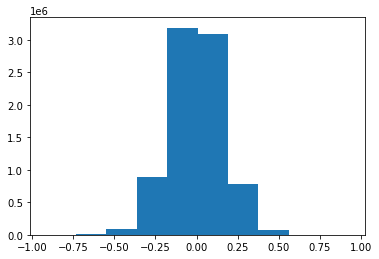

In [10]:
plt.hist(stim.ravel())

In [11]:
if fps == 10:
    tap = 8
elif fps == 25:
    tap = 20
elif fps == 30:
    tap = 24

## calc STA and peak-to-peak difference for all RGCs

In [12]:
# choose a channel
sta_p2ps = []
sta_psnrs = []

for ch_idx in range(spike_counts.shape[0]):

    channel_name = info['channel'][ch_idx]
    cell_types = info['cell_type'][ch_idx]
    print(channel_name, cell_types)
    

    spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

    sta = np.average(spike_triggered_stim, weights=weights, axis=0)
    # sta.shape
    
    sta_p2ps.append(p2p(sta))
    sta_psnrs.append(psnr(sta))

#     print(spike_triggered_stim.shape)

#     plot_spatio_temporal(sta, ylabel='STA') #, 
#     #                     fig_basename=os.path.join('figure', 'sta', channel_name))
#     # plt.title(channel_name + '(%.2f)'.format)

info['sta_p2p'] = sta_p2ps
info['sta_psnr'] = sta_psnrs

info.to_csv(dataset + '_sta.csv', index=None)

12a ON
12b Unknown
13a ON
13b ON
14a ON
14b OFF
14c ON-OFF
14d ON
16a ON-OFF
16b ON
16c ON
16d ON
17a ON-OFF
17b ON
21a OFF
21b ON
21c ON
21d ON
22a ON
22b ON
22c ON
23a ON
23b ON-OFF
23c Unknown
24a OFF
24b ON
24c ON
24d ON
25a ON
25b ON-OFF
25c OFF
26a ON
26b ON-OFF
26c OFF
28a ON
28b ON
28c ON
33a ON-OFF
33b Unknown
33c ON
33d ON
34a ON-OFF
34b ON
35a ON
36a OFF
36b ON
37a OFF
37b ON
37c ON-OFF
38a ON-OFF
38b ON-OFF
38c ON-OFF
41a ON-OFF
41b ON
42a ON
42b ON
42c ON
43a ON
45a ON-OFF
45b ON-OFF
45c ON
46a ON-OFF
47a ON
47b ON
47c ON
47d Unknown
48a OFF
48b ON
51a ON
51b ON
52a ON
52b ON
54a ON
57a ON-OFF
57b ON-OFF
58a ON-OFF
58b ON-OFF
61a ON
61b Unknown
61c Unknown
62a ON
62b ON
62c ON
62d ON
63a OFF
63b ON
63c ON
63d ON
64a ON-OFF
64b ON-OFF
64c ON-OFF
68a ON
68b ON
71a Unknown
71b Unknown
71c Unknown
71d Unknown
71e Unknown
73a ON
73b Unknown
73c Unknown
74a Unknown
74b Unknown
74c Unknown
77a OFF
77b ON
78a OFF
78b ON-OFF
86a ON
87a ON-OFF
87b ON-OFF


## analyze results

In [13]:
# # dataset = '20201209'
# # info = pd.read_csv('20201209_sta.csv')

# dataset = '20201216'
# info = pd.read_csv('20201216_sta.csv')


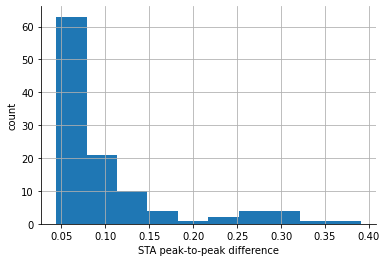

In [14]:
info['sta_p2p'].hist()
plt.xlabel('STA peak-to-peak difference')
plt.ylabel('count')
box_off()

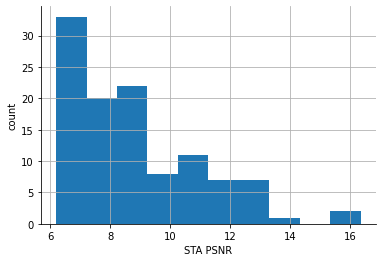

In [15]:
info['sta_psnr'].hist()
plt.xlabel('STA PSNR')
plt.ylabel('count')
box_off()

In [16]:
idx_high_snr = info['sta_p2p'] >= 0.35
info[idx_high_snr].sort_values(by='sta_p2p', ascending=False)

,channel,cell_type,sta_p2p,sta_psnr
40,33d,ON,0.390318,10.61431


In [17]:
if len(info['cell_type'].value_counts()) == 3: # ON, OFF, Unknown
    group_values = ['ON', 'OFF', 'Unknown']
    color=['r','#00A0FF', '#A0A0A0']
elif len(info['cell_type'].value_counts()) == 4: # ON, OFF, ON-OFF, Unknown
    group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown']
    color=['r','#00A0FF','green', '#A0A0A0']    

In [18]:
info.groupby('cell_type', sort=False).mean()

,sta_p2p,sta_psnr
cell_type,,
ON,0.103968,8.914468
Unknown,0.104071,7.866128
OFF,0.083071,8.817599
ON-OFF,0.102773,9.348425


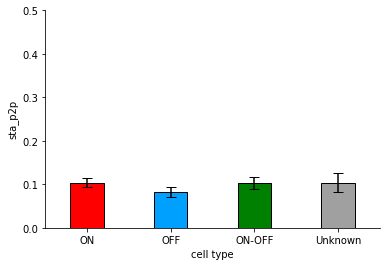

In [19]:
plot_bar_by_group(info, 'sta_p2p',
                  group_values = group_values, color=color)

plt.ylim(0, 0.5)
plt.savefig("figure/sta_{}_p2p_bar.pdf".format(dataset), bbox_inches='tight')
plt.savefig("figure/sta_{}_p2p_bar.png".format(dataset), bbox_inches='tight')

In [20]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.18019699634902256
0.8811714818561067


In [21]:
idx_high_snr = info['sta_psnr'] >= 8
info[idx_high_snr].sort_values(by='sta_psnr', ascending=False)

,channel,cell_type,sta_p2p,sta_psnr
50,38b,ON-OFF,0.337067,16.341505
92,68b,ON,0.310452,15.897139
13,17b,ON,0.168938,13.572473
63,47b,ON,0.136252,12.911136
25,24b,ON,0.219132,12.634806
...,...,...,...,...
71,52b,ON,0.073663,8.239729
79,61c,Unknown,0.095849,8.198685
28,25a,ON,0.062929,8.155278
60,45c,ON,0.066584,8.122153


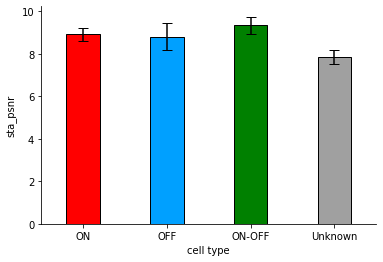

In [22]:
plot_bar_by_group(info, 'sta_psnr',
                  group_values = group_values, color=color)

plt.savefig("figure/sta_{}_psnr_bar.pdf".format(dataset), bbox_inches='tight')
plt.savefig("figure/sta_{}_psnr_bar.png".format(dataset), bbox_inches='tight')

In [23]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_psnr', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

# t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['ON-OFF'], equal_var=False)
# print(p)

0.8944080591082416
0.023183950766316207


## spatio-temporal analysis of RF with ON or OFF RGC with high peak-to-peak difference

In [43]:
# choose a channel with highest p2p
idx_on = info['cell_type'] == 'ON'
idx_off = info['cell_type'] == 'OFF'
idx = np.logical_or(idx_on, idx_off)

ch_idx = info.loc[idx]['sta_p2p'].idxmax()
# ch_idx = info.loc[idx]['sta_psnr'].idxmax()   #PSNR is better criteria

In [44]:
channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

33d ON


peak-to-peak diff. = 0.39


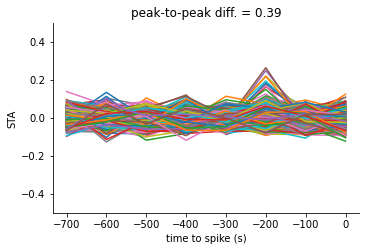

<Figure size 432x288 with 0 Axes>

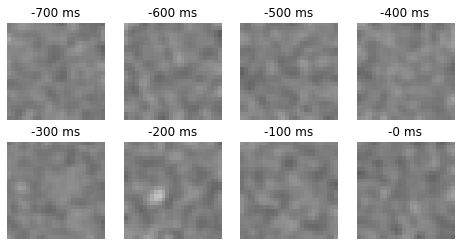

In [45]:
if fps == 10:
    tap = 8
elif fps == 25:
    tap = 20
elif fps == 25:
    tap = 24

sta = pysta.calc_sta(stim, spike_counts[ch_idx], tap=tap)

import os
if not os.path.exists(os.path.join('figure', dataset)):
    os.makedirs(os.path.join('figure', dataset))
    
plot_spatio_temporal(sta, 
                     width=width, height=height, dt=1000/fps,
                     ylabel='STA',
                     fig_basename=os.path.join('figure', dataset, channel_name+'_sta'))
# plt.title(channel_name + '(%.2f)'.format)

### spatial spectrum

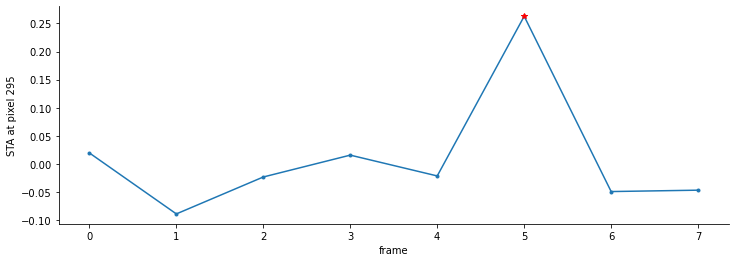

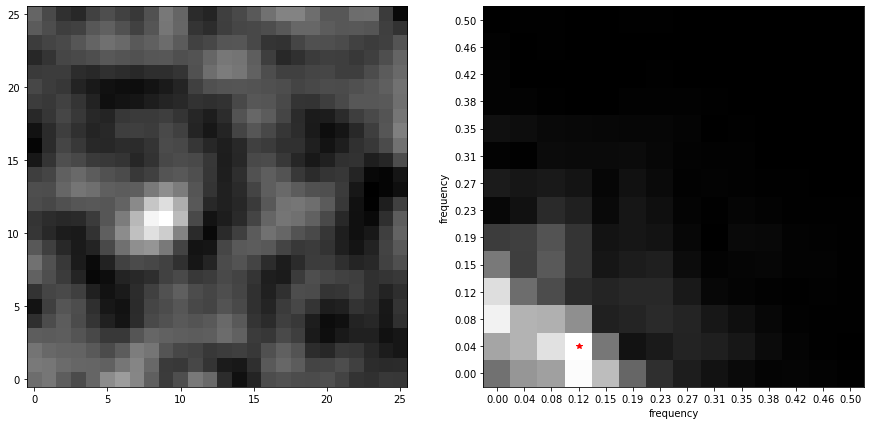

In [46]:
calc_spatial_spectrum(sta)

plt.savefig(os.path.join('figure',dataset, channel_name + '_sta_space_spectrum.pdf'))

### temporal spectrum

peak-to-peak diff. = 0.39


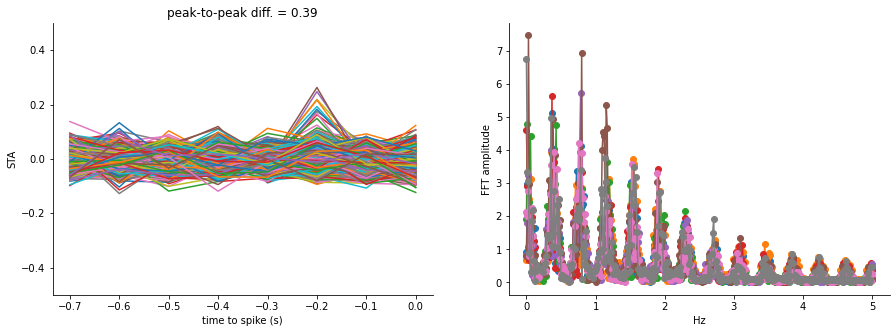

In [47]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plot_temporal_profile(sta, 1/fps)

plt.subplot(122)
plot_temporal_spectrum(sta, 1/fps)

plt.savefig(os.path.join('figure',dataset, channel_name + '_sta_temp_spectrum.pdf'))

In [48]:
# actual frequency values
rfftfreq(tap, 1/fps)

array([0.  , 1.25, 2.5 , 3.75, 5.  ])

## calc regularized STA

In [49]:
sta_reg = pysta.normalize_sta(stim, sta)

In [ ]:
plot_spatio_temporal(sta_reg, 
                     width=width, height=height, dt=1000/fps,
                     ylabel='rSTA')
#                      fig_basename=os.path.join('figure', 'rsta', channel_name))

In [ ]:
# spatial spectrum
calc_spatial_spectrum(sta_reg)

plt.savefig(os.path.join('figure',dataset, channel_name + '_rsta_space_spectrum.pdf'))

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plot_temporal_profile(sta_reg, 1/fps)

plt.subplot(122)
plot_temporal_spectrum(sta_reg, 1/fps)

plt.savefig(os.path.join('figure',dataset, channel_name + '_rsta_temp_spectrum.pdf'))
